<h1 align="center" style="margin-top:10px">Lesson 4</h1>
<h2 align="center" style="margin-top:10px">Classification task.</h2>

The classification problem differs from the regression problem in that the set of all possible target values is known in advance. Because of this, we will apply other models with new loss functions. We'll start with logistic regression and use it as an example to study everything you need to know about the classification problem and then learn how to apply more sophisticated methods.

## Logistic Regression

We use this method when want to classify data into categories, or classes, by predicting the probability that an observation falls into a particular class based on its features.

Though it can be extended to more than two categories, logistic regression is often used for binary classification, i.e. determining which of two groups a data point belongs to, or whether an event will occur or not. In this article, we will focus on binary logistic regression. In practice, a lot of problems come down to binary classification.

In fact, logistic regression is based on linear regression.


We are going to practice on the task of prediction an acquisition. In our case, it is equivalent to the user making a purchase. Let's download the data.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#sns.set_context('notebook') 
sns.set_style('ticks')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
data = pd.read_csv('CustomerAcquisition.csv', index_col=[0],decimal=',')
data.head(10)

,Acquisition,First_Purchase,CLV,Duration,Censor,Acq_Expense,Acq_Expense_SQ,Industry,Revenue,Employees,Ret_Expense,Ret_Expense_SQ,Crossbuy,Frequency,Frequency_SQ
Customer,,,,,,,,,,,,,,,
1,1,433.64,0.00,384,0,760.36,578147.33,1,30.16,1240,2309.79,5335129.84,5,2,4
2,0,0.00,0.00,0,0,147.70,21815.29,1,39.80,166,0.00,0.00,0,0,0
3,0,0.00,0.00,0,0,252.56,63786.55,1,54.93,1016,0.00,0.00,0,0,0
4,1,225.84,5.73,730,1,609.73,371770.67,1,45.83,122,2192.59,4807450.91,2,12,144
5,1,363.04,0.00,579,0,672.36,452067.97,1,69.03,313,801.14,641825.30,4,7,49
6,0,0.00,0.00,0,0,435.57,189721.22,0,22.54,359,0.00,0.00,0,0,0
7,0,0.00,0.00,0,0,362.90,131696.41,0,32.97,902,0.00,0.00,0,0,0
8,0,0.00,0.00,0,0,883.54,780642.93,0,22.48,264,0.00,0.00,0,0,0
9,1,599.30,6.92,730,1,452.35,204620.52,1,17.98,1782,1340.75,1797610.56,1,11,121


### Offtop about acquisition

In this case, the acquisition is equivalent to the fact that the user has made a purchase. But the target action may vary from business to business. Generalizing, we can say that by acquisition we mean attracting a client. For example, if we don't sell anything but monetize through advertising, we might target registrations or just displaying content. You always have some channels to attract users. They can be paid, or they can be free. ***Can you give some examples?***

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/attr1.png?raw=true:, width=800" alt="My Image" width=800>

The user rarely learns about us through one channel. Usually he encounters several channels in sequence. And so businesses are faced with the important task of attribution - the fair contribution of each channel to the payment. We can use simple attribution: first or last click, linear or time decay. But nothing prevents you from using smarter models: Markov chains or vector Shepley.

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/attr2.png?raw=true:, width=800" alt="My Image" width=800>

In [ ]:
data.dtypes

Acquisition         int64
First_Purchase    float64
CLV               float64
Duration            int64
Censor              int64
Acq_Expense       float64
Acq_Expense_SQ    float64
Industry            int64
Revenue           float64
Employees           int64
Ret_Expense       float64
Ret_Expense_SQ    float64
Crossbuy            int64
Frequency           int64
Frequency_SQ        int64
dtype: object

So we have information about the customer: whether he made a purchase or not, how much money we spent to make him buy something from us, and information about the customer himself: his income and profit, as well as the number of employees. Let's start with a simple model that would help us understand how much we need to spend on average for a customer to buy something from us.

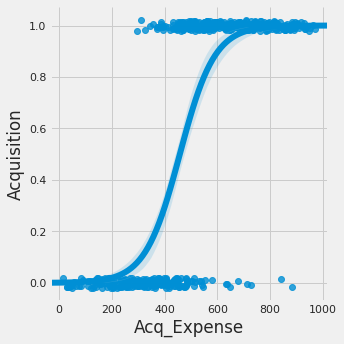

In [ ]:
plt.rcParams['figure.figsize'] = (10, 15)
sns.lmplot(data=data,x='Acq_Expense',y='Acquisition',y_jitter=.02,logistic=True, truncate=False)

We can try to build a linear regression, but it will take values from minus infinity to plus infinity.

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/1p.png?raw=true:, width=800" alt="My Image" width=800>

We want to predict the probability, and it takes values from 0 to 1. Thus, we need a function that displays our predictions for this segment. And fortunately, we have it. The odds are the ratio of the probability of success to the probability of failure. But they cannot be negative. That is why we must additionally take the logarithm.

Thus the following chain is obtained: we know our expense and we can predict the logarithm of the odds, and from that we can already get a probability of acquisition.

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/2p.png?raw=true:, width=800" alt="My Image" width=800>

The maximum likelihood method is used to select the coefficients. Imagine, you arrive in an unfamiliar city. You come to the central square and see a working fountain. You have two hypotheses. The fountain works every day. The fountain is turned on once a year and you are very fortunate to arrive. Both hypotheses may be correct. Except that in the first hypothesis, the probability of seeing a working fountain is 1, and in the second hypothesis, the probability of seeing a working fountain is 1/365. And so the maximum likelihood method says choose the hypothesis where the probability is higher. A little more formally: we will choose the parameters of our model so that the probability of getting such data will be maximum. To do this, we write down the likelihood function.

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/3p.png?raw=true:, width=800" alt="My Image" width=800>

For the example in the picture, the maximum likelihood function would have the following value:

\begin{align}
        (1-0.1)*(1-0.1)*(1-0.1)*(1-0.2)*0.2*0.8*(1-0.8)*0.9*0.9*0.9*0.9= 0.0122444
    \end{align}

If we express the probability from the odds equation, we get the formula

$$ P(y=1|X) =  \frac{\mathrm{1} }{\mathrm{1} + e^-z }  $$ 


where

$$ z = \hat \beta_0 + \hat \beta_1*x_1+...+\hat \beta_n*x_n $$ 

This resulting probability is then compared to a threshold to predict a class for y based on X. Imagine a horizontal line on a graph. And we will say that all values below it have Acquisition = false, and those above it are True. This is our threshold.

It turns out that maximizing the maximum likelihood function is equivalent to minimizing the follow loss function.

\begin{align}
        LogLoss = \sum_{i=1}^n -(y_i*log(p_i)+(1-y_i)*log(1-p_i))
    \end{align}

Thus, we can both maximize the likelihood function and minimize the logloss.

In [ ]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
logit.fit(data.loc[:,['Acq_Expense']] , data['Acquisition'])

LogisticRegression()

Thus, the basic logistic regression for this problem looks like this.

In [ ]:
print(f'P(Acquisition) = {logit.intercept_} + {logit.coef_}*Acq_Expense')

P(Acquisition) = [-6.95526629] + [[0.01518916]]*Acq_Expense


Okay, let's say we learned how to build a linear regression. But how do we find the threshold?

## Metrics in the classification problem.

Usually, the first idea that arises when we want to evaluate the quality of a binary classification is: let's calculate the accuracy. Accuracy is the percentage of correctly predicted observations. However, imagine that we have one class with 900 observations and another with only 100 observations. Then if we always predict the value of the first class, our accuracy is still 90%. That is why accuracy is very rarely used as a main quality metric.

Let's introduce a confusion matrix.

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/conf_m.png?raw=true:, width=800" alt="My Image" width=800>

Instead of looking at the model's raw accuracy (the number of correctly assigned categories divided by te total number of predictions) , the confusion matrix decomposes predictions into several categories of interest, making explicit how one class may be confused for another:

* True Positives (TP): The number of positive instances correctly classified as positive. E.g., predicting user acquisition when we catched him.
* False Positives (FP): The number of negative instances incorrectly classified as positive. E.g., predicting user acquisition when he ignored us.
* True Negatives (TN): The number of negative instances correctly classified as negative. E.g., predicting user acquisition is false when it is actually false.
* False Negatives (FN): The number of positive instances incorrectly classified as negative. E.g., predicting that we can't acquire user when we can do it.

The distinction between these four different prediction outcomes is often consequential, so it's very important to have a solid understanding of them!

One such metric is precision. Precision is the ratio of correctly predicted positive classes to all items predicted to be positive. In other words, what percentage of the predicted users as acquisition equal TRUE we will be able to attract.

$$ Precision =  \frac{\mathrm{TP} }{\mathrm{TP+FP}}  $$ 


We should choose this metric if we care a lot about attracting users and we cannot afford to spend extra money.

A related metric is recall. Recall is the ratio of correctly predicted positive classes to all items that are actually positive. In other words, that's how many of all users we could have acquired, we found.

$$ Recall =  \frac{\mathrm{TP} }{\mathrm{TP+FN}}  $$ 


We should prefer this metric if our goal is to grow quickly and attract as many users as possible.

Ideally, our model would have both perfect precision and perfect recall. However, in practice there often exists a tradeoff between the two.

Because of this tradeoff, it's important to understand the problem that you're trying to solve and any inherent consequences of favoring False Positives over False Negatives (or vice versa).

Take another example: model which predict cancer: designing a model with high recall will identify most people that have cancer (true positives), saving their lives, but at the cost of misdiagnosing healthy individuals as having cancer (false positives), subjecting them to expensive and dangerous treatments like chemotherapy. On the other hand, designing a model for precision yields confident diagnoses (i.e. someone predicted as having cancer very likely does have cancer), but at the cost of failing to identify everyone who has the disease (false negatives), resulting in potentially fatal consequences for those left undiagnosed. (Because False Negatives result in death, our classification threshold would likely be set to optimize recall over precision).

Thus, it's important to understand and decide ahead of time what's more consequential, False Positives or False Negatives, to investigate how the tradeoff manifests for your particular dataset, and to design your model accordingly.

Given this competing tradeoff, it would be very convenient to have a single performance metric that takes into account both precision and recall. It exist and called F-1 score. The F1-score (also sometimes called the F-Measure) is a single performance metric that takes both precision and recall into account. It's calculated by taking the harmonic mean of the two metrics::

$$ F1 =  \frac{\mathrm{2*Precision*Recall} }{\mathrm{Precision+Recall}}  $$ 


For this reason, it takes values from zero to one, with values closer to one indicating better performance, and values closer to zero indicating poorer performance. In situations where either precision or recall are poor, the F1-score will also be poor. Only when both precision and recall have good performance will the F1-score be high. 

Why not the arithmetic mean? Because when using the arithmetic mean, the same F-measure can have both equal precision and recall, and zero out one of them. With the harmonic mean, if we rest on the threshold of one of the metrics, then no matter how you increase the second, the F-measure will not grow.

[viz](https://mlu-explain.github.io/precision-recall/)

The F1-score is a great way to compare the performance of multiple classifiers. When choosing between multiple models, all with varying values of precision and/or recall, it may be used to determine which one produces the 'best' results for the problem at hand. For this reason, it's often used in practice as a metric by which to rank models by performance.

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

In [ ]:
# Please note that in order to correctly estimate the results, we need to count the error on the data that were not used during training.
y_pred = logit.predict(data.loc[:,['Acq_Expense']])
confusion_matrix(data['Acquisition'], y_pred) 

array([[178,  30],
       [ 29, 263]])

In [4]:
from sklearn.metrics import plot_confusion_matrix

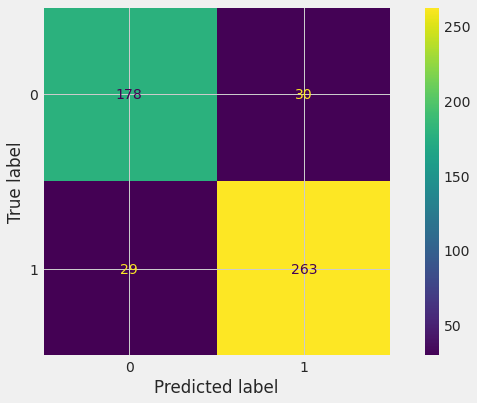

In [ ]:
plot_confusion_matrix(logit,data.loc[:,['Acq_Expense']],data['Acquisition']) 

In [ ]:
print(f"Precision: {np.round(precision_score(data['Acquisition'], y_pred),2)}")
print(f"Recall: {np.round(recall_score(data['Acquisition'], y_pred),2)}")
print(f"F1-score: {np.round(f1_score(data['Acquisition'], y_pred),2)}")
print(f"Recall: {np.round(roc_auc_score(data['Acquisition'], y_pred),2)}")

Precision: 0.9
Recall: 0.9
F1-score: 0.9
Recall: 0.88


#### ROC-AUC as way to choose threshold

In machine learning, we use ROC Curves to analyze the predictive power of a classifier: they provide a visual way to observe how changes in our model’s classification thresholds affect our model’s performance. The curves allow us to select for classification thresholds that allow our model to identify as many true positives as possible while minimizing false positives.

In particular, the ROC curve is composed by plotting a model's True-Positive Rate (TPR) versus its False-Positive Rate (FPR) across all possible classification thresholds, where:

True Positive Rate (TPR): The probability that a positive sample is correctly predicted in the positive class. E.g., the percentage users correct predicted to be actually acquired.
False Positive Rate (FPR): The probability that a negative sample is incorrectly predicted in the positive class. E.g., the percentage users predicted to be acquired that actually ignored us.

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/roc.png?raw=true:, width=800" alt="My Image" width=800>

Let's say we chose the threshold of 0. Then we correctly predict all acquired users. But we also record all non-acquired users as true. We can see that by raising the threshold a little bit, we will still be predicting everyone of acquired users, but we will stop spending extra money on people we definitely can't attract.

By increasing the threshold further we see, for example, that mistakenly saying that a user will be attracted, 20% of the time, we will only find 40% of the users we can acquired.

The ROC Curve is valuable not only because it gives us an overview of our model's performance (and lets us select an optimal classification threshold for that model), but because it also gives us an easy visual to compare the performance of different classifiers to one another.

A perfect classifier is one that hugs along the outer-left and top of the chart. This is expected, as ‘perfect’ here implies the classifier will always have a TPR=1, regardless of the FPR. On the other hand, a diagonal line implies that TPR=FPR for every classification threshold - in other words, the classifier is just making random guesses.

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/roc_comp.png?raw=true:, width=800" alt="My Image" width=800>

When it comes to comparing models, the rule of thumb is that curves that fall above the ROC Curve of a random classifier (the diagonal line) are good or decent. The higher up they are (i.e. the closer they are to the curve of the elusive perfect classifier), the better. Anything below the diagonal line has worse performance than random guessing, so likely isn't worth any consideration.

Our model shows something that hangs somewhere between perfect and random. Indeed, this is the kind of result you’d expect to get in the real-world. Obtaining a perfect or exactly random result likely indicates a problem. An exactly random result may indicate that your problem is not well-framed, and may not have a solution without additional data. If the result shows a perfect classifier, make sure that there is no place where the training data is leaking information about the label which would not be available when the model is in deployment, as such a result likely points to overfitting or data-leakage.

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/comp.png?raw=true:, width=800" alt="My Image" width=800>

AUC is just the area underneath the entire ROC curve. Think integration from calculus. AUC provides us with a nice, single measure of performance for our classifiers, independent of the exact classification threshold chosen. This allows us to compare models to each other without even looking at their ROC curves (though visualizing the performance of your models is never a bad idea!).

AUC ranges in value from 0 to 1, with higher numbers indicating better performance. A perfect classifier will have an AUC of 1, while a perfectly random classifier an AUC of 0.5. A model that always predicts that a negative sample is more likely to have a positive label than a positive sample will have AUC of 0, indicating severe failure on the modeling side. Scores in the range [0.5, 1] imply good performance, while anything under 0.5 indicates very poor performance.

But no one is stopping you from constructing a Precision-Recall curve either.

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/PR.png?raw=true:, width=800" alt="My Image" width=800>

All of these functions are available in sklearn

In [5]:
from sklearn.metrics import roc_curve
y_prob = logit.predict_proba(data.loc[:,['Acq_Expense']])

fpr, tpr, _ = roc_curve(data['Acquisition'], y_prob[:,1])
auc = roc_auc_score(data['Acquisition'], y_prob[:,1])
plt.plot(fpr, tpr, label='Logit' + ' (AUC = {:.3f})'.format(auc))
plt.show()

NameError: ignored

In [6]:
from sklearn.metrics import precision_recall_curve

In [7]:
from sklearn.metrics import PrecisionRecallDisplay

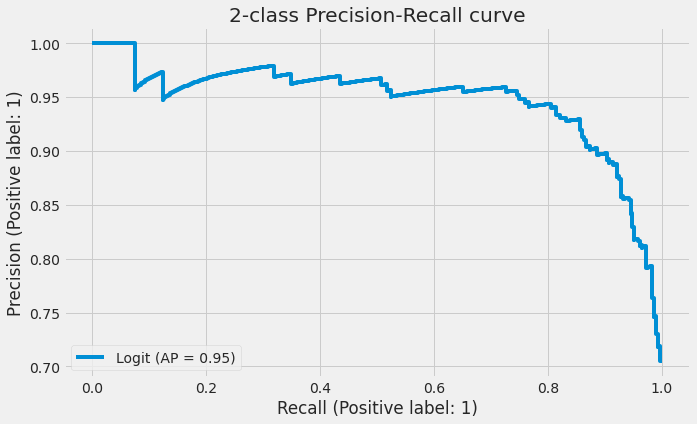

In [ ]:
display = PrecisionRecallDisplay.from_predictions(data['Acquisition'], y_prob[:,1], name="Logit")
_ = display.ax_.set_title("2-class Precision-Recall curve")

## Random Forest

Before you build a random forest, you must deal with its components, namely decision trees.

Decision Trees are widely used algorithms for supervised machine learning. They're popular for their ease of interpretation and large range of applications. They work for both regression and classification problems.
A Decision Tree consists of a series of sequential decisions, or decision nodes, on some data set's features. The resulting flow-like structure is navigated via conditional control statements, or if-then rules, which split each decision node into two or more subnodes. Leaf nodes, also known as terminal nodes, represent prediction outputs for the model.
To train a Decision Tree from data means to figure out the order in which the decisions should be assembled from the root to the leaves. At each step, we try to find the condition that best separates the data contained in the node. New data may then be passed from the top down until reaching a leaf node, representing a prediction for that data point.

It is easy to represent the solving rule as a binary tree, as in the picture.

[full image](https://mlu-explain.github.io/decision-tree/)

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/IMG_0013.jpeg?raw=true:, width=800" alt="My Image" width=800>

Given the large number of potential options, how exactly does the algorithm determine where to partition the data? Before we learn how that works, we need to understand Entropy. 

\begin{align}
        H = - \sum_{i=1}^n p_i*log_2(p_i)
    \end{align}

When we consider a decision tree, $p_i$ is the fraction of observations of class $i$. 

Properties:
* H=0 only if all but one of the pi are zero, this one having the value of 1. Thus the entropy vanishes only when there  is no uncertainty in the outcome, meaning that the sample is completely unsurprising.
* H is maximum when all the $p_i$ are equal

Thus, as we move from parent to child nodes, we want to maximize the amount of information we get.

As the name implies, information gain measures an amount the information that we gain. It does so using entropy. The idea is to subtract from the entropy of our data before the split the entropy of each possible partition thereafter. We then select the split that yields the largest reduction in entropy, or equivalently, the largest increase in information. 

It's a recursive procedure that starts from the root node of the tree and iterates top-down on all non-leaf branches in a greedy manner, calculating at each depth the difference in entropy:

\begin{align}
        \Delta H = H_{parent}- \frac{\mathrm{1} }{\mathrm{N}} \sum_{children} N_{child}*H_{child}
    \end{align}

### Basic hyperparameters that are configured in decision trees.

* max depth - How many conditions can be used when predicting a single instance
* min samples split - the minimum number of samples required to split an internal node
* min samples leaf - The minimum number of samples required to be at a leaf node. In each of two leaf.
* max features - he number of features to consider when looking for the best split. 
* min impurity decrease - A node will be split if this split induces a decrease of the impurity greater than or equal to this value

By changing these parameters we fight overtraining

In [8]:
from sklearn.tree import DecisionTreeClassifier

In [9]:
from sklearn.model_selection import train_test_split

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, random_state=1)

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

response = 'Acquisition'
predictors = ['Acq_Expense', 'Revenue', 'Employees', 'Industry']

y_train = train[response]
y_test = test[response]
X_train = train[predictors]
X_test = test[predictors]

In [10]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [68]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model = DecisionTreeClassifier(criterion='entropy')

tuning_parameters = {
    'min_samples_leaf': [1,5,10,20,30,40,50],
     'max_depth': [2,4,5,6,8],
}

tree_search = GridSearchCV(model, tuning_parameters, cv= 5 , return_train_score=False)
tree_search.fit(X_train, y_train)

tree = tree_search.best_estimator_

print('Best parameters found by grid search:', tree_search.best_params_, '\n')

Best parameters found by grid search: {'max_depth': 4, 'min_samples_leaf': 1} 



In [7]:
import graphviz
from sklearn.tree import export_graphviz

In [17]:
pd.DataFrame(y_train).value_counts()

Acquisition
1              197
0              153
dtype: int64

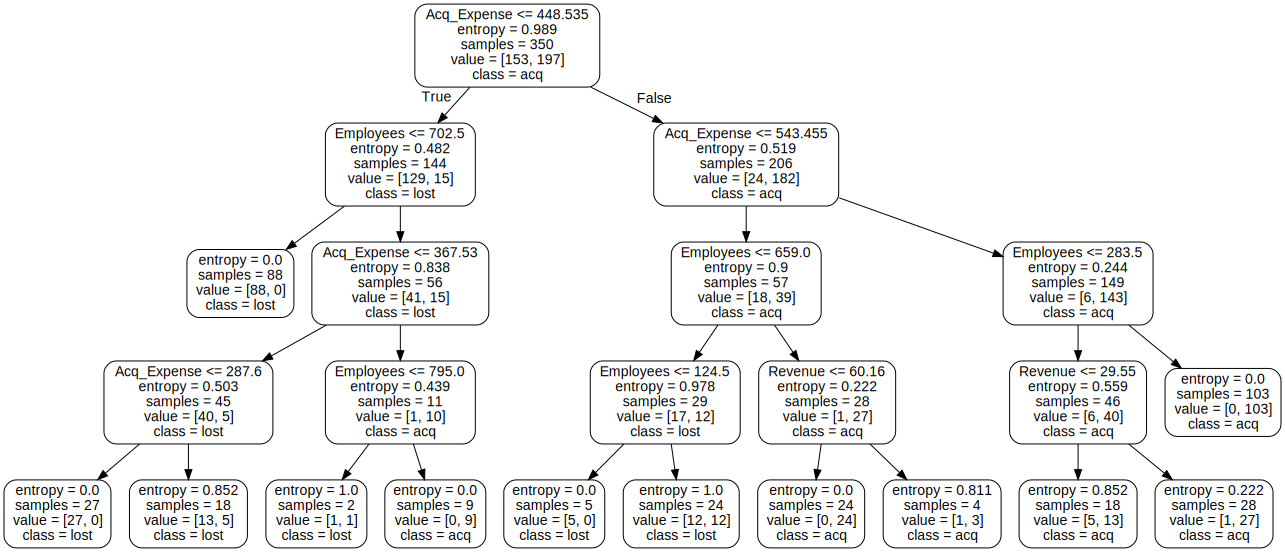

In [18]:
dot_data = export_graphviz(tree, out_file=None, feature_names=predictors, impurity=True,
                           class_names=['lost','acq'], rounded=True) 
graph = graphviz.Source(dot_data)
graph.render('tree') # saves tree to a file
graph

For example, you can see from this tree that if the company size is less than 659, then we have to spend more than $543.455. We also see that we can shrink the tree, without losing quality.

[Shap theory](https://hughchen.github.io/its_blog/index.html)

In [11]:
!pip install shap -q

     |████████████████████████████████| 575 kB 4.2 MB/s 


In [12]:
import shap

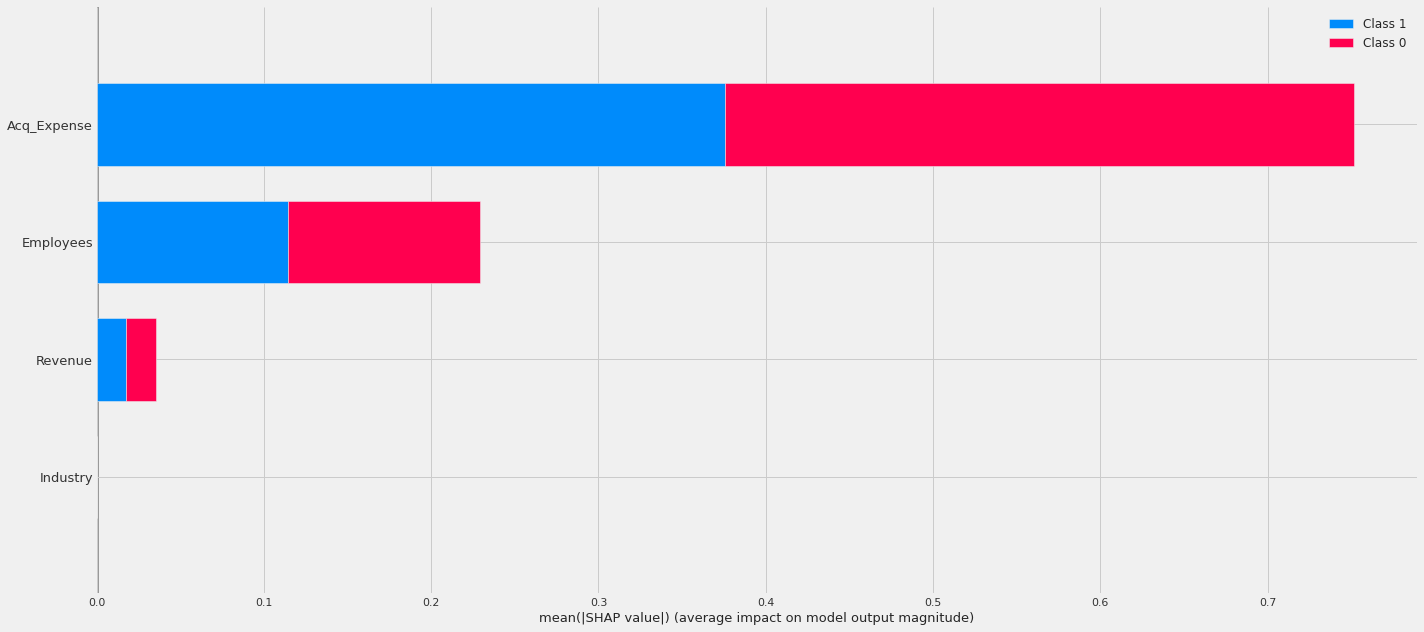

In [71]:
shap.initjs()
explainer = shap.TreeExplainer(tree,X_train, feature_names=X_train.columns)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values,X_train, plot_size=(20,9),feature_names=X_train.columns)

Shap has the ability to show something similar to a decision tree, but unfortunately the example from the documentation does not work for the decision tree...

## Random forest

The idea of the random forest is well illustrated by one theorem and one example. 
Condorcet's theorem: if each member of the jury has an independent opinion, and if the probability of a jury member being right is greater than 0.5 (in the case of machine learning we talk about classifier, such as a decision tree, instead of a judge), then the probability of the jury as a whole being right increases with the number of jurors and tends to unity. If the probability of each juror being right is less than 0.5, then the probability of the jury as a whole making a correct decision monotonically decreases and tends to zero as the number of jurors increases.

An example, then, is called the wisdom of the crowd. I don't know if this is true or not, but following story exists. Francis Galton visited a market in 1906 where a sort of lottery was being held for peasants. About 800 of them gathered and tried to guess the weight of the bull that stood in front of them. The bull weighed 1,198 pounds. Not a single peasant guessed the exact weight of the bull, but if you count the average of their predictions, you get 1,197 pounds.

For crowds to be wise, they must be characterized by a diversity of opinions, and each person's opinion must be independent of those around him.


When in machine learning we combine several classifiers into one, we say that we are dealing with an ensemble.

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/rf.png?raw=true:, width=800" alt="My Image" width=800>

Ensemble learning creates a stronger model by aggregating the predictions of multiple weak models, such as decision trees (check out our previous article on Decision Trees to learn more about some of their limitations). Condorcet’s Jury Theorem suggests that the majority vote aggregation can have better accuracy than the individual models. There are other methods to aggregate predictions, such as weighted majority vote.

Random Forest is an example of ensemble learning where each model is a decision tree.

One way to produce multiple models that are different is to train each model using a different training set. The Bagging (Bootstrap Aggregating) method randomly draws a fixed number of samples from the training set with replacement. This means that a data point can be drawn more than once.

For each split of the tree building, we compute the best splitting using only a randomly selected subset of the features. This is another way to ensure that the decision trees are as different as possible. We choose a random set of features for each node of the tree.

The final class is chosen by a majority.

We previously discussed how decision tree model suffers from high variance. However, this variance among trees is employed in the random forest as a feature, not a bug. The high variance of the decision tree model can help keep the correlation among trees low. The Bagging Method as well as the Feature Selection are the key innovations to keep correlation low. 

We still have the ability to choose hyperparameters for decision trees, but also new ones that apply only to the random forest appear.

* n_estimators - number of trees in the forest
* bootstrap - whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

And note that now importance of *max_features* highly increase

In [13]:
from sklearn.ensemble import  RandomForestClassifier

In [100]:
model = RandomForestClassifier(criterion = 'entropy',  n_estimators=1000)

tuning_parameters = {
    'n_estimators':[10,50,100,1000],
    'min_samples_leaf': [1, 5, 10, 20, 50],
    'max_features': np.arange(1, len(predictors)+1),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 16, return_train_score=False, n_jobs=4)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'n_estimators': 1000, 'min_samples_leaf': 10, 'max_features': 3} 



In [101]:
rf.fit(X_train, y_train) 

RandomForestClassifier(criterion='entropy', max_features=3, min_samples_leaf=10,
                       n_estimators=10000)

For a random forest, we can't build a tree, because in our case there are a thousand of them.

 99%|===================| 695/700 [02:17<00:00]       

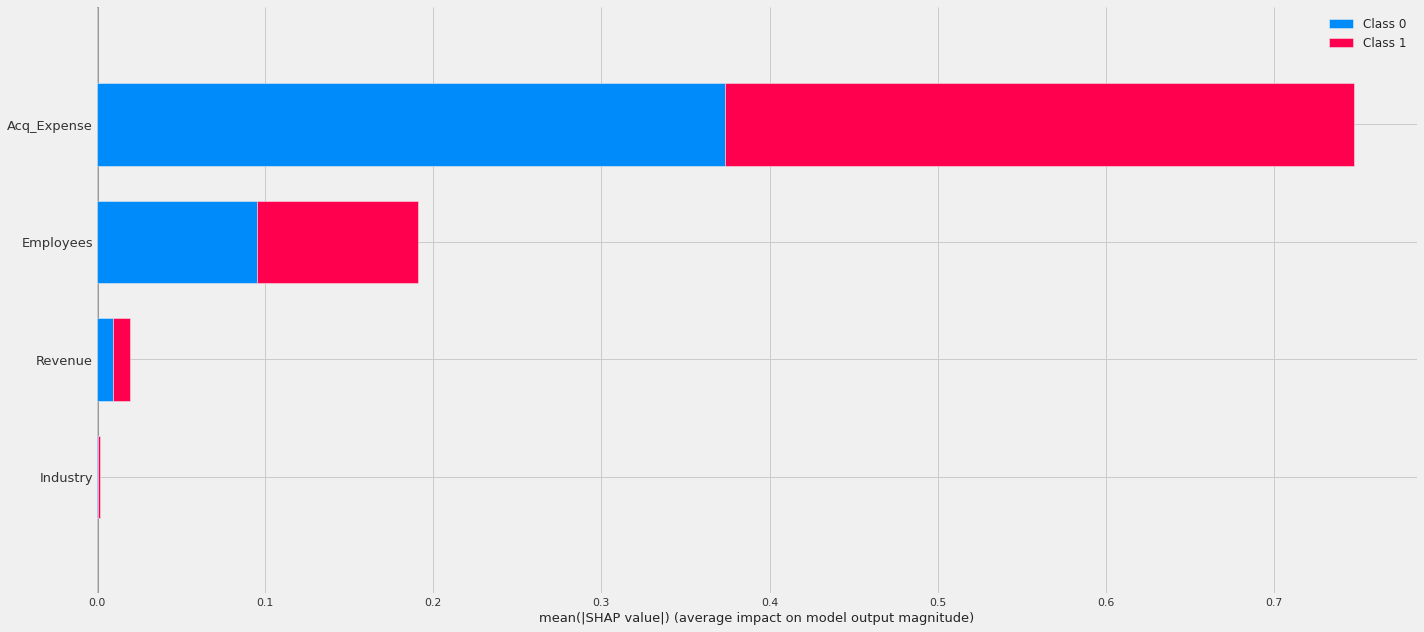

In [102]:
shap.initjs()
explainer = shap.TreeExplainer(rf,X_train, feature_names=X_train.columns)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values,X_train, plot_size=(20,9),feature_names=X_train.columns)

## Boosting

This algorithm is part of the everyday "gentleman's kit" of models worth trying in the next task. It also uses a lot of weak models, but it doesn't do it like a random forest. It took more than 10 years from the moment of its appearance to take its place in the "gentlemen's set". First, the basic GBM had many extensions for different statistical tasks. Second, there are many implementations of GBM under different names and platforms: Stochastic GBM, GBDT (Gradient Boosted Decision Trees), GBRT (Gradient Boosted Regression Trees), MART (Multiple Additive Regression Trees), GBM as Generalised Boosting Machines and others. In addition, the machine-learner communities were rather fragmented and did everything in a row, which makes it difficult to track the progress of boosting. At the same time, the boosting began to be actively used in the task of ranking search engine output. This task was written out in terms of a loss function that penalizes for errors in the order of output, so it became convenient to just insert it into GBMs. AltaVista was one of the first to implement boosting in the ranking, and they were soon followed by Yahoo, Yandex, Bing and others. And speaking of implementation, we were talking about boosting becoming the main algorithm within working engines for years to come, rather than just another interchangeable research stunt living within the confines of a couple of research articles.

ML competitions, especially kaggle, have played a major role in popularizing boosting. Researchers have long lacked a common platform with enough participants and tasks for people with their algorithms and approaches to compete in an open competition for the state of the art. The dusky German geniuses who grew the next miracle algorithm in their garage could not be written off as closed data, while the real breakthrough libraries on the contrary received an excellent platform for development. That's exactly what happened with boosting, which caught on at kaggle almost immediately (look for GBM in interviews with winners since 2011), while xgboost as a library quickly gained popularity shortly after its appearance. That said, xgboost is not some new unique algorithm, but simply an extremely efficient implementation of classical GBM with some additional heuristics. XGboost is still one of the most popular implementations of gradient boosting, along with lightgbm and catboost.


Let's take example with the principle of work of gradient boosting.

In our toy example, we are going to predict whether a person will like the movie Trolls 2. What other features could you add to this model.

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/GBM1.png?raw=true:, width=800" alt="My Image" width=800>

We start with a basic prediction: in the regression problem this is the mean value, and in the classification problem log(odds).

$log(odds)=log(4/2) = 0.69$

We get initial prediction. How can we use it for prediction? We will use logistic function.

$$ P(y=1|X) =  \frac{\mathrm{1} }{\mathrm{1} + e^-log(odds) }  $$ 

So our initial probability 0.67

Let's take threshold 0.5, then we classify all people as loves Trolls 2. Very bad model, but better than random. Next, we need to calculate how much we are wrong when we use such a simple model. Let's round our basic prediction to make our calculation easy.

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/gbm2.png?raw=true:, width=800" alt="My Image" width=800>

We will now and continue to use decision trees to predict errors. But the tree must be really small

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/gbm3.png?raw=true:, width=800" alt="My Image" width=800>

We now have two classifiers. В случае задачи регрессии мы могли бы сложить результаты. Но так как наша модель возвращает вероятности, мы должны воспользоваться формулой.

$$ P(y=1|X) =  \frac{\mathrm{sum(Residuals_i)} }{\mathrm{sum(Previous \, probability_i*(1-Previous \, probability_i))} }  $$ 

Then we use this formula to recalculate the value in each sheet. We calculate the new probability. 0.8 is the lernig rate (the parameter from the gradient descent)

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/gbm4.png?raw=true:, width=800" alt="My Image" width=800>

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/gbm5.png?raw=true:, width=800" alt="My Image" width=800>

Our model has become more complex, and there are fewer errors. We will continue to add new models step by step, increasing the accuracy. This process ends when we have built the specified number of trees or several iterations in a row we cannot increase the accuracy.

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/gbm6.png?raw=true:, width=800" alt="My Image" width=800>

In [14]:
import lightgbm as lgb

In [17]:
random_state = 7
X_train_lgb, X_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)
d_train = lgb.Dataset(X_train_lgb, label=y_train_lgb)
d_test = lgb.Dataset(X_valid_lgb, label=y_valid_lgb)

In [18]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "random_state": random_state
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.23968


In [23]:
y_pred = np.where(model.predict(X_test)>0.5,1,0)

In [24]:
print(f"Precision: {np.round(precision_score(y_test, y_pred),2)}")
print(f"Recall: {np.round(recall_score(y_test, y_pred),2)}")
print(f"F1-score: {np.round(f1_score(y_test, y_pred),2)}")
print(f"Recall: {np.round(roc_auc_score(y_test, y_pred),2)}")

Precision: 0.92
Recall: 0.93
F1-score: 0.92
Recall: 0.89


In [19]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

features = X_train_lgb
features_display = X_train_lgb.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: [0.41963882]


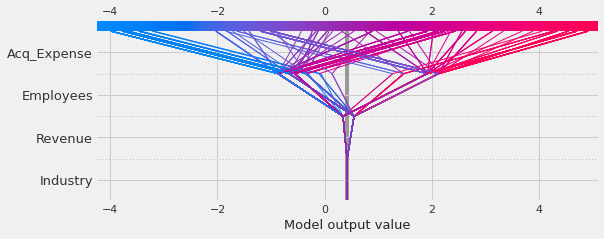

In [20]:
shap.decision_plot(expected_value, shap_values, features_display)

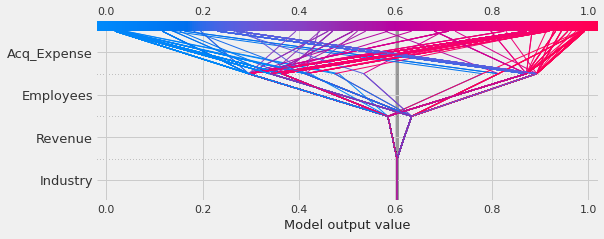

In [21]:
shap.decision_plot(expected_value, shap_values, features_display, link='logit')

The x-axis represents the model’s output. The plot is centered on the x-axis at explainer.expected_value. All SHAP values are relative to the model’s expected value like a linear model’s effects are relative to the intercept. * The y-axis lists the model’s features. By default, the features are ordered by descending importance.

Each observation’s prediction is represented by a colored line. At the top of the plot, each line strikes the x-axis at its corresponding observation’s predicted value. This value determines the color of the line on a spectrum. * Moving from the bottom of the plot to the top, SHAP values for each feature are added to the model’s base value. This shows how each feature contributes to the overall prediction. * At the bottom of the plot, the observations converge at explainer.expected_value.

We can't build a decision tree, but we can hypothesize.

We have so many hyperparameters that we can pick up on cross-validation:

[docs](https://lightgbm.readthedocs.io/en/v3.3.2/Parameters.html)

* objective function
* boosting (type of boosting) 
* num_iterations (how much classifiers we will use)
* learning_rate
* num_leaves (max number of leaves in one tree)
* max_depth
* min_data_in_leaf
* bagging_fraction
* feature_fraction
* early_stopping_round
* lambda_l1
* lambda_l2
* min_gain_to_split
* drop rate and max drope

[EFB](https://datascience.stackexchange.com/questions/41907/lightgbm-why-exclusive-feature-bundling-efb)

[Target encoding](https://ai.plainenglish.io/understand-catboost-intuition-and-training-process-e0bf258065f2)